# Assignment Details

For this assignment we collect the visual data from the Sentinel2 Satelite to predict urban heat index. The band data is collected in a separate notebook that is almost identical to the sample notebook provided. The written answer to the question is at the end of the notebook.

# Ignore Challenge Info

Many studies suggest that the density of buildings in a
city influences ground temperatures and ultimately
contribute to the UHI issue. [Reference 3] This effect is
typically driven by buildings blocking the flow of air and
adding waste heat. For this challenge, we have
provided a building footprint dataset. Such information
could be used in your digital model as a feature that
drives local urban heating. 

Local weather data can also be an important
feature in a UHI model. For example, high wind
speeds can cause mixing of near-surface air and
reduce UHI intensity and variability. Wind direction
can also impact localized heating as building
configurations can block local mixing of nearsurface air and cause increased urban heating.
Finally, solar flux can be blocked by clouds or
building configurations which could reduce local
surface heating and near-surface air heating. 

 Up to ten semifinalists will be selected based on the highest overall accuracy in the form of a coefficient of determination (Rsquared)

<h10 style="color:rgb(255, 255, 0)"><strong>Note: Participants are strictly prohibited from using Longitude and Latitude values as features in building their machine learning models. These values should only be utilized for understanding the attributes and characteristics of the locations. Submissions that employ longitude and latitude values as model features will be disqualified.</strong></h10>

In [1]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Science
import numpy as np
import pandas as pd

# Multi-dimensional arrays and datasets
import xarray as xr

# Geospatial raster data handling
import rioxarray as rxr

# Geospatial data analysis
import geopandas as gpd

# Geospatial operations
import rasterio
from rasterio import windows  
from rasterio import features  
from rasterio import warp
from rasterio.warp import transform_bounds 
from rasterio.windows import from_bounds 

# Image Processing
from PIL import Image

# Coordinate transformations
from pyproj import Proj, Transformer, CRS

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

# Planetary Computer Tools
import pystac_client
import planetary_computer as pc
from pystac.extensions.eo import EOExtension as eo

# Others
import os
from tqdm import tqdm


In [2]:
ground_df = pd.read_csv("Training_data_uhi_index_UHI2025-v2.csv")
ground_df.head()

Longitude   Latitude          datetime  UHI Index
0 -73.909167  40.813107  24-07-2021 15:53   1.030289
1 -73.909187  40.813045  24-07-2021 15:53   1.030289
2 -73.909215  40.812978  24-07-2021 15:53   1.023798
3 -73.909242  40.812908  24-07-2021 15:53   1.023798
4 -73.909257  40.812845  24-07-2021 15:53   1.021634

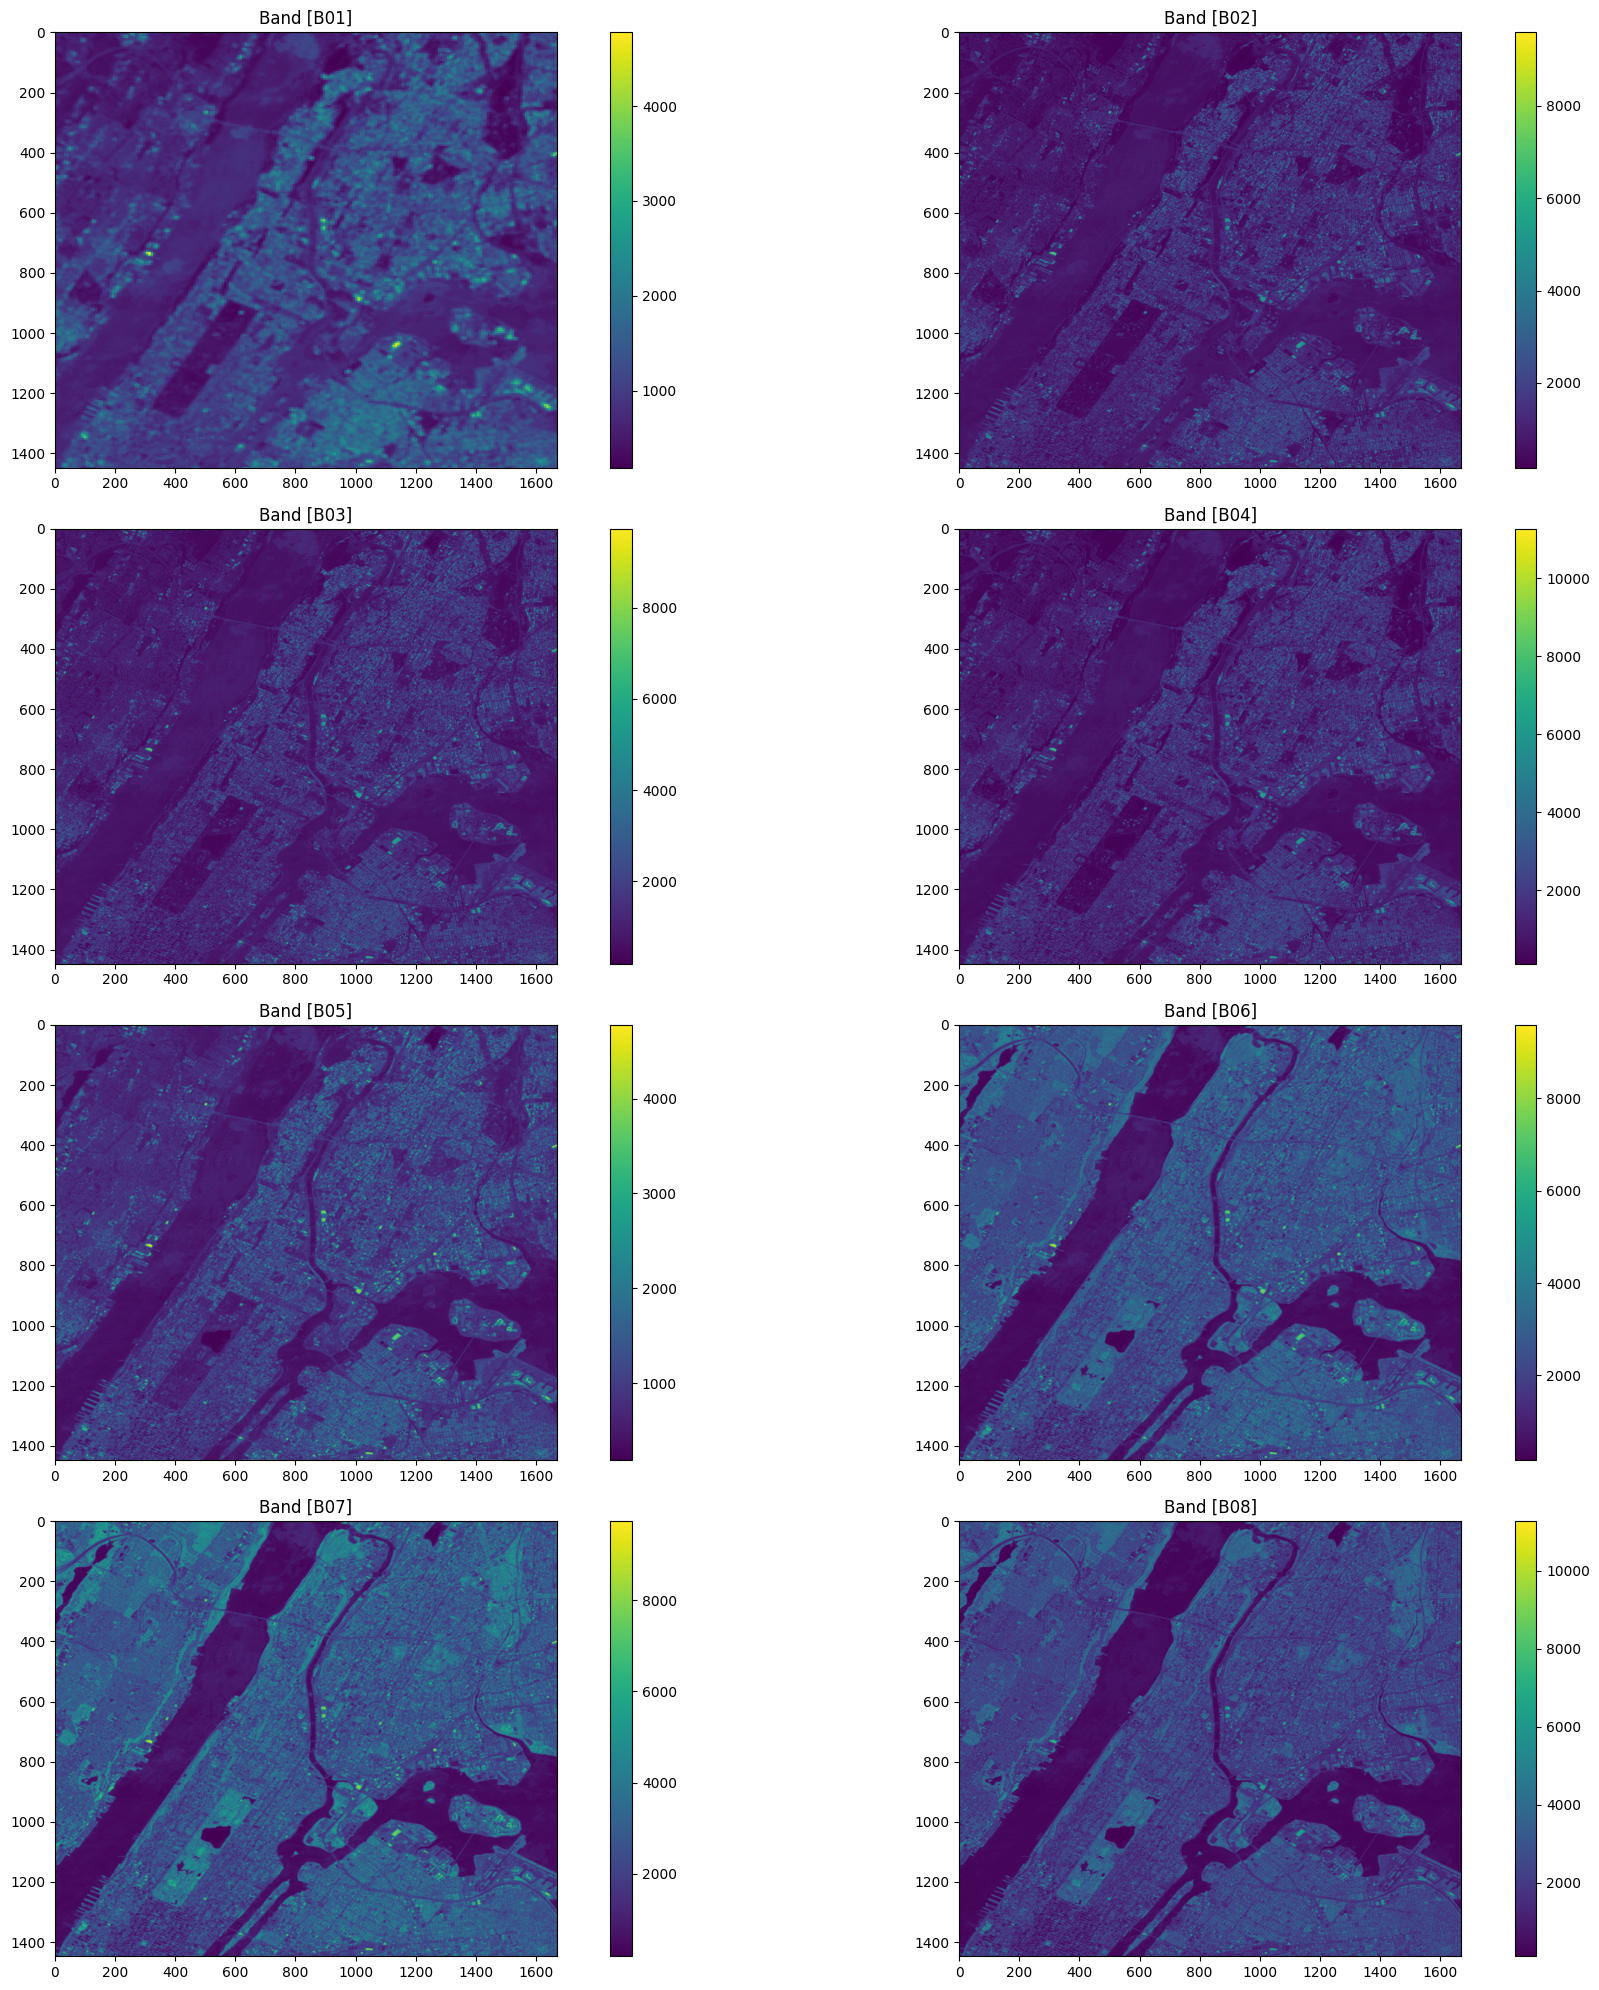

In [3]:
# Reads and plots four bands (B04, B08, B06, B01) from the GeoTIFF file.

# Open the GeoTIFF file
tiff_path = "S2_sample.tiff"

# Read the bands from the GeoTIFF file
with rasterio.open(tiff_path) as src1:
    band1 = src1.read(1)  # Band [B01]
    band2 = src1.read(2)  # Band [B02]
    band3 = src1.read(3)  # Band [B03]
    band4 = src1.read(4)  # Band [B04]
    band5 = src1.read(5)  # Band [B05]
    band6 = src1.read(6)  # Band [B06]
    band7 = src1.read(7)  # Band [B07]
    band8 = src1.read(8)  # Band [B08]
    band9 = src1.read(9)  # Band [B8A]
    band10 = src1.read(10)  # Band [B11]
    band11 = src1.read(11)  # Band [B12]

# Plot the bands in a 2x2 grid
fig, axes = plt.subplots(4, 2, figsize=(20, 20))

# Flatten the axes for easier indexing
axes = axes.flatten()
    
# Plot the first band (B01)
im1 = axes[0].imshow(band1, cmap='viridis')
axes[0].set_title('Band [B01]')
fig.colorbar(im1, ax=axes[0])

# Plot the second band (B02)
im2 = axes[1].imshow(band2, cmap='viridis')
axes[1].set_title('Band [B02]')
fig.colorbar(im2, ax=axes[1])

# Plot the third band (B04)
im3 = axes[2].imshow(band3, cmap='viridis')                 
axes[2].set_title('Band [B03]')
fig.colorbar(im3, ax=axes[2])

# Plot the fourth band (B04)
im4 = axes[3].imshow(band4, cmap='viridis')
axes[3].set_title('Band [B04]')
fig.colorbar(im4, ax=axes[3])

# Plot B05
im5 = axes[4].imshow(band5, cmap='viridis')
axes[4].set_title('Band [B05]')
fig.colorbar(im1, ax=axes[4])

# Plot B06
im6 = axes[5].imshow(band6, cmap='viridis')
axes[5].set_title('Band [B06]')
fig.colorbar(im2, ax=axes[5])

# Plot B07
im7 = axes[6].imshow(band7, cmap='viridis')                 
axes[6].set_title('Band [B07]')
fig.colorbar(im3, ax=axes[6])

# Plot B08
im8 = axes[7].imshow(band8, cmap='viridis')
axes[7].set_title('Band [B08]')
fig.colorbar(im4, ax=axes[7])

plt.tight_layout()
plt.show()


Instead of a single point data extraction, participants might explore the approach of creating a focal buffer around the locations (e.g., 50 m, 100 m, 150 m etc). For example, if the specified distance was 50 m and the specified band was “Band 2”, then the value of the output pixels from this analysis would reflect the average values in band 2 within 50 meters of the specific location. This approach might help reduction in error associated with spatial autocorrelation. In this demonstration notebook, we are extracting the band data for each of the locations without creating a buffer zone.

In [4]:
# Extracts satellite band values from a GeoTIFF based on coordinates from a csv file and returns them in a DataFrame.

def map_satellite_data(tiff_path, csv_path):
    
    # Load the GeoTIFF data
    data = rxr.open_rasterio(tiff_path)
    tiff_crs = data.rio.crs

    # Read the Excel file using pandas
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # 3. Convert lat/long to the GeoTIFF's CRS
    # Create a Proj object for EPSG:4326 (WGS84 - lat/long) and the GeoTIFF's CRS
    proj_wgs84 = Proj(init='epsg:4326')  # EPSG:4326 is the common lat/long CRS
    proj_tiff = Proj(tiff_crs)
    
    # Create a transformer object
    transformer = Transformer.from_proj(proj_wgs84, proj_tiff)

    B01_values = []
    B02_values = []
    B03_values = []
    B04_values = []
    B05_values = []
    B06_values = []
    B07_values = []
    B08_values = []
    B8A_values = []
    B11_values = []
    B12_values = []

# Iterate over the latitudes and longitudes, and extract the corresponding band values
    for lat, lon in tqdm(zip(latitudes, longitudes), total=len(latitudes), desc="Mapping values"):
    # Assuming the correct dimensions are 'y' and 'x' (replace these with actual names from data.coords)
    
        B01_value = data.sel(x=lon, y=lat,  band=1, method="nearest").values
        B01_values.append(B01_value)
    
        B02_value = data.sel(x=lon, y=lat, band=2, method="nearest").values
        B02_values.append(B02_value)
        
        B03_value = data.sel(x=lon, y=lat, band=3, method="nearest").values
        B03_values.append(B03_value)
    
        B04_value = data.sel(x=lon, y=lat, band=4, method="nearest").values
        B04_values.append(B04_value)
                
        B05_value = data.sel(x=lon, y=lat,  band=5, method="nearest").values
        B05_values.append(B05_value)
    
        B06_value = data.sel(x=lon, y=lat, band=6, method="nearest").values
        B06_values.append(B06_value)
        
        B07_value = data.sel(x=lon, y=lat, band=7, method="nearest").values
        B07_values.append(B07_value)
    
        B08_value = data.sel(x=lon, y=lat, band=8, method="nearest").values
        B08_values.append(B08_value)
        
        B8A_value = data.sel(x=lon, y=lat,  band=9, method="nearest").values
        B8A_values.append(B8A_value)
    
        B11_value = data.sel(x=lon, y=lat, band=10, method="nearest").values
        B11_values.append(B11_value)
        
        B12_value = data.sel(x=lon, y=lat, band=11, method="nearest").values
        B12_values.append(B12_value)
    
    # Create a DataFrame with the band values
    # Create a DataFrame to store the band values
    df = pd.DataFrame()
    df['B01'] = B01_values
    df['B02'] = B02_values
    df['B03'] = B03_values
    df['B04'] = B04_values
    df['B05'] = B05_values
    df['B06'] = B06_values
    df['B07'] = B07_values
    df['B08'] = B08_values
    df['B8A'] = B8A_values
    df['B11'] = B11_values
    df['B12'] = B12_values
    
    return df


In [5]:
# Mapping satellite data with training data.
final_data = map_satellite_data('S2_sample.tiff', 'Training_data_uhi_index_UHI2025-v2.csv')

Mapping values: 100%|██████████| 11229/11229 [00:40<00:00, 275.48it/s]


In [6]:
final_data.head()

B01     B02     B03     B04     B05     B06     B07     B08     B8A  \
0  841.5  1053.0  1155.0  1206.0  1481.5  1660.5  1721.0  1832.0  1709.0   
1  841.5  1053.0  1155.0  1206.0  1481.5  1660.5  1721.0  1832.0  1709.0   
2  841.5   646.0   823.0   777.0  1130.5  1883.0  2117.5  2241.0  2251.0   
3  841.5   625.0   766.0   741.5  1130.5  1883.0  2117.5  2200.0  2251.0   
4  841.5   659.5   763.0   708.5  1077.5  1783.0  2042.0  2161.0  2186.0   

      B11     B12  
0  1792.0  1495.5  
1  1792.0  1495.5  
2  1548.0  1135.0  
3  1548.0  1135.0  
4  1617.5  1207.5

# Formulas for artificial band indices

In [7]:
# Calculate NDVI (Normalized Difference Vegetation Index) and handle division by zero by replacing infinities with NaN.
# See the Sentinel-2 sample notebook for more information about the NDVI index
final_data['NDVI'] = (final_data['B08'] - final_data['B04']) / (final_data['B08'] + final_data['B04'])
final_data['NDVI'] = final_data['NDVI'].replace([np.inf, -np.inf], np.nan) 

# Buildup index
final_data['NDBI'] = (final_data['B11'] - final_data['B08']) / (final_data['B11'] + final_data['B08'])
final_data['NDBI'] = final_data['NDBI'].replace([np.inf, -np.inf], np.nan)


# Bare Soil Index (BSI): Good for bare soil identification (limitation of Buildup Index)
final_data['BSI'] = ((final_data['B04']**2 + final_data['B11']**2)) ** 0.5 / 2
final_data['BSI'] = final_data['BSI'].replace([np.inf, -np.inf], np.nan)

# Urban Index (UI): Differentiates urban areas from vegetation
final_data['UI'] = (final_data['B11'] - final_data['B03']) / (final_data['B11'] + final_data['B03'])
final_data['UI'] = final_data['UI'].replace([np.inf, -np.inf], np.nan)


# Moisture Index (NDMI): Assesses vegetation water content, also good for identifying water
final_data['NDMI'] = (final_data['B08'] - final_data['B11']) / (final_data['B08'] + final_data['B11'])
final_data['NDMI'] = final_data['NDMI'].replace([np.inf, -np.inf], np.nan)

In [8]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [9]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df,final_data)
uhi_data.head()

Longitude   Latitude          datetime  UHI Index    B01     B02     B03  \
0 -73.909167  40.813107  24-07-2021 15:53   1.030289  841.5  1053.0  1155.0   
1 -73.909187  40.813045  24-07-2021 15:53   1.030289  841.5  1053.0  1155.0   
2 -73.909215  40.812978  24-07-2021 15:53   1.023798  841.5   646.0   823.0   
3 -73.909242  40.812908  24-07-2021 15:53   1.023798  841.5   625.0   766.0   
4 -73.909257  40.812845  24-07-2021 15:53   1.021634  841.5   659.5   763.0   

      B04     B05     B06     B07     B08     B8A     B11     B12      NDVI  \
0  1206.0  1481.5  1660.5  1721.0  1832.0  1709.0  1792.0  1495.5  0.206057   
1  1206.0  1481.5  1660.5  1721.0  1832.0  1709.0  1792.0  1495.5  0.206057   
2   777.0  1130.5  1883.0  2117.5  2241.0  2251.0  1548.0  1135.0  0.485089   
3   741.5  1130.5  1883.0  2117.5  2200.0  2251.0  1548.0  1135.0  0.495835   
4   708.5  1077.5  1783.0  2042.0  2161.0  2186.0  1617.5  1207.5  0.506186   

       NDBI          BSI        UI      NDMI  
0 -0.011038  1080.011574  0.216152  0.011038  
1 -0.011038  1080.011574  0.216152  0.011038  
2 -0.182898   866.030167  0.305778  0.182898  
3 -0.173959   858.214171  0.337943  0.173959  
4 -0.143840   882.932401  0.358958  0.143840

## Removing duplicates
Identical or duplicate entries are removed based on specific columns, in our case [ 'B01','B04','B06','B08','NDVI']. This ensures that the dataset is not biased or skewed by repetitive data, allowing the model to train on unique, relevant observations.

In [10]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['B01','B02','B03','B04','B05','B06','B07','B08','B8A', 'B11', 'B12', 'NDVI','NDBI','BSI','UI','NDMI']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head()


Longitude   Latitude          datetime  UHI Index    B01     B02     B03  \
0 -73.909167  40.813107  24-07-2021 15:53   1.030289  841.5  1053.0  1155.0   
2 -73.909215  40.812978  24-07-2021 15:53   1.023798  841.5   646.0   823.0   
3 -73.909242  40.812908  24-07-2021 15:53   1.023798  841.5   625.0   766.0   
4 -73.909257  40.812845  24-07-2021 15:53   1.021634  841.5   659.5   763.0   
6 -73.909312  40.812710  24-07-2021 15:53   1.015143  841.5   551.5   768.5   

      B04     B05     B06     B07     B08     B8A     B11     B12      NDVI  \
0  1206.0  1481.5  1660.5  1721.0  1832.0  1709.0  1792.0  1495.5  0.206057   
2   777.0  1130.5  1883.0  2117.5  2241.0  2251.0  1548.0  1135.0  0.485089   
3   741.5  1130.5  1883.0  2117.5  2200.0  2251.0  1548.0  1135.0  0.495835   
4   708.5  1077.5  1783.0  2042.0  2161.0  2186.0  1617.5  1207.5  0.506186   
6   659.0  1077.5  1783.0  2042.0  2472.0  2186.0  1617.5  1207.5  0.579048   

       NDBI          BSI        UI      NDMI  
0 -0.011038  1080.011574  0.216152  0.011038  
2 -0.182898   866.030167  0.305778  0.182898  
3 -0.173959   858.214171  0.337943  0.173959  
4 -0.143840   882.932401  0.358958  0.143840  
6 -0.208950   873.296520  0.355826  0.208950

In [11]:
uhi_data=uhi_data.reset_index(drop=True)

In [12]:
# Retaining only the columns for features + targetin the dataset.
uhi_data = uhi_data[['UHI Index','B01','B02','B03','B04','B05','B06','B07','B08','B8A', 'B11', 'B12', 'NDVI','NDBI','BSI','UI','NDMI']]

In [13]:
X = uhi_data.drop(columns=['UHI Index'])
y = uhi_data['UHI Index']

In [14]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

ModuleNotFoundError: No module named 'xgboost'

In [ ]:
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up 4-fold cross validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Perform cross validation using R^2 as the scoring metric
cv_scores = cross_val_score(model, X, y, scoring='r2', cv=kf)

print("Cross Validation R^2 scores:", cv_scores)
print("Average R^2:", cv_scores.mean())

Cross Validation R^2 scores: [0.33297016 0.31461948 0.33700004 0.28543844]
Average R^2: 0.31750703172584077


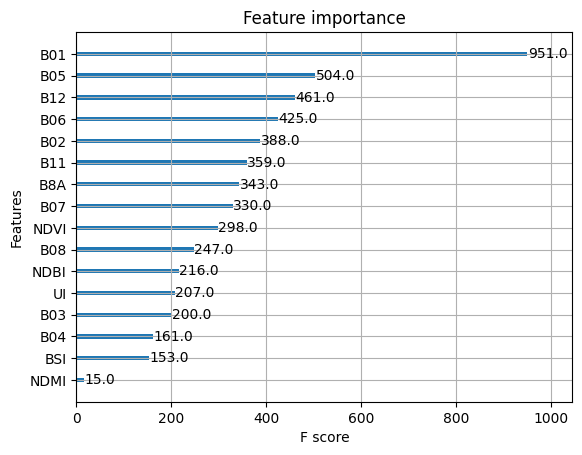

In [ ]:
import pandas as pd
model.fit(X,y)
importances = model.feature_importances_

xgb.plot_importance(model)
plt.show()

In [ ]:
all_bands = X[['B01','B02','B03','B04','B05','B06','B07','B08','B8A', 'B11', 'B12']]
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up 4-fold cross validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Perform cross validation using R^2 as the scoring metric
cv_scores = cross_val_score(model, all_bands, y, scoring='r2', cv=kf)

print("Cross Validation R^2 scores:", cv_scores)
print("Average R^2:", cv_scores.mean())

Cross Validation R^2 scores: [0.37914746 0.40545912 0.37039515 0.34916539]
Average R^2: 0.37604177972815256


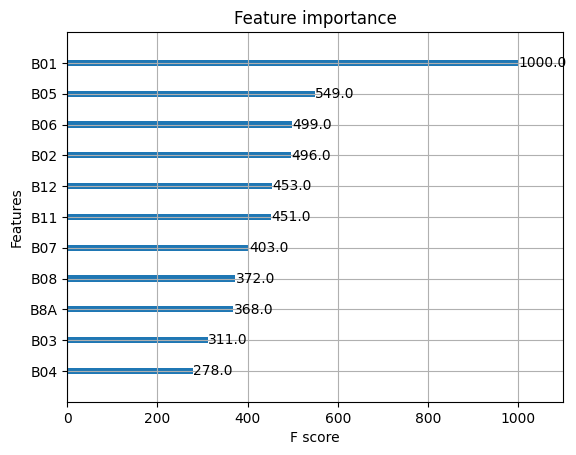

In [ ]:
model.fit(all_bands,y)
importances = model.feature_importances_

xgb.plot_importance(model)
plt.show()

In [ ]:
all_indices = X[['NDVI','NDBI','BSI','UI','NDMI']]
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up 4-fold cross validation
kf = KFold(n_splits=4, shuffle=True, random_state=42)

# Perform cross validation using R^2 as the scoring metric
cv_scores = cross_val_score(model, all_indices, y, scoring='r2', cv=kf)

print("Cross Validation R^2 scores:", cv_scores)
print("Average R^2:", cv_scores.mean())

Cross Validation R^2 scores: [-0.04539876 -0.02362927 -0.05604444 -0.08357467]
Average R^2: -0.0521617849123317


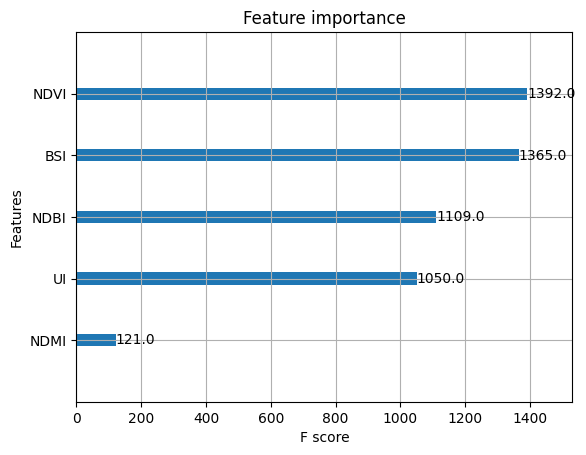

In [ ]:
model.fit(all_indices,y)
importances = model.feature_importances_

xgb.plot_importance(model)
plt.show()

Our question we are aiming to tackle with this preliminary model is: Which environmental factors affect UHI intensity the most?

This question will be addressed using a regression since we will be quantifying how our features affect the UHI intensity on a continuous scale. No classifier nor clustering model would be able to solve this as we want to see a distribution of intensities rather than bins or classes. Also, this question will not be able to be answered with just one model. Instead, we will conduct some feature importance analysis to see which of our features affect the UHI intensity the most by subsetting our features into various regression models. Then, by seeing the accuracy of the models, we will be able to tell which features, most likely, hold the greatest tell into UHI intensity. 

To answer this, we are looking at the Sentinal-2 sateline output which holds data on the satelite firing light with varying wavelengths and capturing the intensity of the reflected light. This holds very useful insight into our question as by creating combinations of the wavelengths, and understanding how vegetation and urbanization reacts to these combinations, we can see what logitude and latitude points have high vegetation/interesting information and then compare those points to the heat index thereby seeing which features are important in predicting UHI intensity. Again, this can be done using a regression model. Our model of choice is an xgboost.

To formulas for the indices we created can be referenced above. Here are interpretations of the indices we created using other features:

- NDVI measures vegetation health by detecting how much light is absorbed by plants versus reflected. High values indicate dense, healthy vegetation, while low values suggest sparse or stressed plants, making it useful for agriculture, forestry, and environmental monitoring.

- NDBI identifies urban areas by highlighting surfaces that reflect more infrared light. It is commonly used for tracking urban expansion, land-use changes, and assessing built-up density.

- BSI detects exposed soil by analyzing differences in reflectance between soil and other surfaces. It helps in cleaning up noise caused by bare soil in the NDBI.

- UI enhances the detection of built-up areas by contrasting urban landscapes with natural environments. It is particularly useful for distinguishing cities and infrastructure from vegetation in satellite imagery.

- NDMI measures vegetation water content, making it valuable for monitoring drought conditions, forest fire risk, and agricultural water stress.

The initial model that contains all bands of light as well as the indexes or linear combination of bands has an R^2 of 0.318 after cross-validation. We are measuring model performance in terms of R^2 since the EY Data Challenge ranks models based on this metric. The roughly translates to the percent of variance the model explains about the target variable. In addition, the feature importance is plotted which is measured in terms of F score. F score is just one metric of feature importance and simply tallies the number of times that a certain feature was split on. From the first feature importance plot, we see that the "most important" feature was the B01 band at 951 splits whereas the least important feature was the NDMI which only had 15 splits. This model contained a lot of multi-colinearity since the indices were exactly derived from linear combinations of other features. This implies that the cross-correlation between features might be high, leading to dubious measures of feature importance. We can see the effect multicolinearity has from the second model training. Training on only the band values led to an R^2 of 0.376, which is a notable increase from the first model. The multi-colinearity causes our model to overfit to the training data by masking by features have the most explanatory power. Finally, the third model actually causes our predictions to be worse than predicting the average. Even though, NDVI had the highest feature importance, the model has no negative predictive power, so the meaning of importance is lost in this context. Overall, this demonstrates that the possibility of colinearity in the data is real and measures to combat this should be considered. For future modeling we will consider implement L1 and L2 regularization as hyperparameters for our model and potentially doing a best subset selection to ensure that all features within the model increasing the evaluation metric.

# Feature Selection: LR

In [15]:
building_area_df = pd.read_csv('Building_Area.csv')

In [16]:
building_area_df.head()

Longitude   Latitude          datetime  UHI Index  building_area_25  \
0 -73.909167  40.813107  24-07-2021 15:53   1.030289        183.978594   
1 -73.909187  40.813045  24-07-2021 15:53   1.030289        266.930647   
2 -73.909215  40.812978  24-07-2021 15:53   1.023798        321.122238   
3 -73.909242  40.812908  24-07-2021 15:53   1.023798        343.873068   
4 -73.909257  40.812845  24-07-2021 15:53   1.021634        382.402733   

   building_area_50  building_area_100  
0       1597.323120       11046.690248  
1       1729.473614       10814.226850  
2       1951.435804       10525.136565  
3       2287.039351       10446.113598  
4       2652.734741       10479.891453

In [17]:
uhi_data = combine_two_datasets(ground_df,final_data)
uhi_data = uhi_data.drop(columns= ['UHI Index', 'datetime', 'NDVI','NDBI','BSI','UI','NDMI'])

merged_df = pd.merge(building_area_df, 
                     uhi_data, 
                     on=['Longitude', 'Latitude'])

In [18]:
X = merged_df.drop(columns = ['Longitude', 'Latitude', 'datetime', 'UHI Index'])
Y = merged_df['UHI Index']

In [19]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr = LinearRegression()

r2_scores = cross_val_score(lr, X, Y, cv=5, scoring='r2')

print("R-squared scores for each fold:", r2_scores)
print("Mean R-squared:", r2_scores.mean())


R-squared scores for each fold: [ 0.08940937 -0.12425457 -0.61124925 -0.29996386 -0.27724743]
Mean R-squared: -0.2446611496530294


In [20]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

# Optionally, split into training and testing sets for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize the linear regression model
lr = LinearRegression()

# Use ExhaustiveFeatureSelector to search for the best subset of features.
# Here we set min_features=1 and max_features to the total number of predictors.
efs = EFS(lr,
          min_features=1,
          max_features=X_train.shape[1],
          scoring='r2',
          print_progress=True,
          cv=5)

# Fit the feature selector on the training data
efs = efs.fit(X_train, y_train)

# Get the best feature subset found
best_subset = efs.best_feature_names_
print("Best subset of features:", best_subset)


# Train a final model using only the best subset
lr.fit(X_train[list(best_subset)], y_train)
y_pred = lr.predict(X_test[list(best_subset)])

# Evaluate the final model using R-squared
r2 = r2_score(y_test, y_pred)
print("Test R-squared:", r2)


ModuleNotFoundError: No module named 'mlxtend'

# Lasso Regression

In [21]:
building_area_df = pd.read_csv('Building_Area.csv')
uhi_data = combine_two_datasets(ground_df,final_data)
uhi_data = uhi_data.drop(columns= ['UHI Index', 'datetime', 'NDVI','NDBI','BSI','UI','NDMI'])

merged_df = pd.merge(building_area_df, 
                     uhi_data, 
                     on=['Longitude', 'Latitude'])

merged_df

Longitude   Latitude          datetime  UHI Index  building_area_25  \
0     -73.909167  40.813107  24-07-2021 15:53   1.030289        183.978594   
1     -73.909187  40.813045  24-07-2021 15:53   1.030289        266.930647   
2     -73.909215  40.812978  24-07-2021 15:53   1.023798        321.122238   
3     -73.909242  40.812908  24-07-2021 15:53   1.023798        343.873068   
4     -73.909257  40.812845  24-07-2021 15:53   1.021634        382.402733   
...          ...        ...               ...        ...               ...   
11224 -73.957050  40.790333  24-07-2021 15:57   0.972470          0.000000   
11225 -73.957063  40.790308  24-07-2021 15:57   0.972470          0.000000   
11226 -73.957093  40.790270  24-07-2021 15:57   0.981124          0.000000   
11227 -73.957112  40.790253  24-07-2021 15:59   0.981245          0.000000   
11228 -73.957128  40.790237  24-07-2021 15:59   0.983408          0.000000   

       building_area_50  building_area_100    B01     B02     B03     B04  \
0           1597.323120       11046.690248  841.5  1053.0  1155.0  1206.0   
1           1729.473614       10814.226850  841.5  1053.0  1155.0  1206.0   
2           1951.435804       10525.136565  841.5   646.0   823.0   777.0   
3           2287.039351       10446.113598  841.5   625.0   766.0   741.5   
4           2652.734741       10479.891453  841.5   659.5   763.0   708.5   
...                 ...                ...    ...     ...     ...     ...   
11224          0.000000           0.000000  462.5   491.0   725.5   501.0   
11225          0.000000           0.000000  462.5   506.5   741.5   551.5   
11226          0.000000           0.000000  462.5   506.5   741.5   551.5   
11227          0.000000           0.000000  462.5   506.5   741.5   551.5   
11228          0.000000           0.000000  462.5   640.0   835.0   723.0   

          B05     B06     B07     B08     B8A     B11     B12  
0      1481.5  1660.5  1721.0  1832.0  1709.0  1792.0  1495.5  
1      1481.5  1660.5  1721.0  1832.0  1709.0  1792.0  1495.5  
2      1130.5  1883.0  2117.5  2241.0  2251.0  1548.0  1135.0  
3      1130.5  1883.0  2117.5  2200.0  2251.0  1548.0  1135.0  
4      1077.5  1783.0  2042.0  2161.0  2186.0  1617.5  1207.5  
...       ...     ...     ...     ...     ...     ...     ...  
11224   999.0  2612.0  3111.5  3152.0  3446.5  1925.0  1072.5  
11225   999.0  2612.0  3111.5  3572.0  3446.5  1925.0  1072.5  
11226   999.0  2612.0  3111.5  3572.0  3446.5  1925.0  1072.5  
11227   999.0  2612.0  3111.5  3572.0  3446.5  1925.0  1072.5  
11228  1014.5  2755.0  3407.5  3341.0  3487.0  2106.5  1182.5  

[11229 rows x 18 columns]

In [22]:
merged_df.to_csv('building_and_light_data.csv')

In [ ]:
# For all features

import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = merged_df.drop(columns = ['Longitude', 'Latitude', 'datetime', 'UHI Index'])
Y = merged_df['UHI Index']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)

optimal_alpha = lasso_cv.alpha_
print("Optimal alpha for all features:", optimal_alpha)

y_pred_cv = lasso_cv.predict(X_test)
print("R-squared (CV) for all features:", r2_score(y_test, y_pred_cv))

Optimal alpha for all features: 0.0031863220576280574
R-squared (CV) for all features: 0.13618596230226176


In [ ]:
# For just bandwidths
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = merged_df.drop(columns = ['Longitude', 
                              'Latitude', 
                              'datetime', 
                              'UHI Index', 
                              'building_area_25',
                              'building_area_50',
                              'building_area_100'])
Y = merged_df['UHI Index']


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

lasso_cv = LassoCV(cv=5, random_state=42)
lasso_cv.fit(X_train, y_train)

optimal_alpha = lasso_cv.alpha_
print("Optimal alpha for just bandwidths:", optimal_alpha)

y_pred_cv = lasso_cv.predict(X_test)
print("R-squared (CV) for just bandwidths:", r2_score(y_test, y_pred_cv))

Optimal alpha for just bandwidths: 0.0020963871461727656
R-squared (CV) for just bandwidths: 0.11553046743508555


# xgb experiments

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler


building_area_df = pd.read_csv('Building_Area.csv')
uhi_data = combine_two_datasets(ground_df,final_data)
uhi_data = uhi_data.drop(columns= ['UHI Index', 'datetime', 'NDVI','NDBI','BSI','UI','NDMI'])

merged_df = pd.merge(building_area_df, 
                     uhi_data, 
                     on=['Longitude', 'Latitude'])

merged_df['B01'] = merged_df['B01'].apply(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)
merged_df['B02'] = merged_df['B02'].apply(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)
merged_df['B03'] = merged_df['B03'].apply(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)
merged_df['B04'] = merged_df['B04'].apply(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)
merged_df['B05'] = merged_df['B05'].apply(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)
merged_df['B06'] = merged_df['B06'].apply(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)
merged_df['B07'] = merged_df['B07'].apply(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)
merged_df['B08'] = merged_df['B08'].apply(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)
merged_df['B8A'] = merged_df['B8A'].apply(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)
merged_df['B11'] = merged_df['B11'].apply(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)
merged_df['B12'] = merged_df['B12'].apply(lambda x: x.item() if isinstance(x, np.ndarray) and x.size == 1 else x)

scaler = StandardScaler()



In [ ]:
# only 25 meter radius
scaler = StandardScaler()
X = scaler.fit_transform(merged_df.drop(columns=['B8A', 'Longitude', 'Latitude', 'datetime', 'UHI Index', 'building_area_50', 'building_area_100']))
y = merged_df['UHI Index']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print("R-squared scores for each fold:", r2_scores)
print("Mean R-squared:", r2_scores.mean())


R-squared scores for each fold: [ 0.08997143 -0.11476031 -0.59043808 -0.23487048 -0.26177653]
Mean R-squared: -0.2223747940929483


In [ ]:
# only 50 meter radius
X = scaler.fit_transform(merged_df.drop(columns=['B8A', 'Longitude', 'Latitude', 'datetime', 'UHI Index', 'building_area_25', 'building_area_100']))
y = merged_df['UHI Index']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print("R-squared scores for each fold:", r2_scores)
print("Mean R-squared:", r2_scores.mean())


R-squared scores for each fold: [-0.00289445 -0.29766701 -0.6808999  -0.4327481  -0.37474233]
Mean R-squared: -0.35779035773170637


In [ ]:
# only 100 meter radius
X = scaler.fit_transform(merged_df.drop(columns=['B8A', 'Longitude', 'Latitude', 'datetime', 'UHI Index', 'building_area_50', 'building_area_25']))
y = merged_df['UHI Index']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print("R-squared scores for each fold:", r2_scores)
print("Mean R-squared:", r2_scores.mean())


R-squared scores for each fold: [-0.01245609 -0.25614813 -0.59108192 -0.43846489 -0.35883689]
Mean R-squared: -0.33139758465412494


# Just using Buildings

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler

building_area_df = pd.read_csv('Building_Area.csv')



In [ ]:
X = building_area_df.drop(columns=['Longitude', 'Latitude', 'datetime', 'UHI Index', 'building_area_50', 'building_area_100'])
y = building_area_df['UHI Index']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print("R-squared scores for each fold:", r2_scores)
print("Mean R-squared:", r2_scores.mean())

R-squared scores for each fold: [-0.09401956 -0.08432901 -0.97502219 -0.01859394 -0.27071274]
Mean R-squared: -0.2885354871115148


In [ ]:
X = building_area_df.drop(columns=['Longitude', 'Latitude', 'datetime', 'UHI Index', 'building_area_25', 'building_area_100'])
y = building_area_df['UHI Index']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print("R-squared scores for each fold:", r2_scores)
print("Mean R-squared:", r2_scores.mean())

R-squared scores for each fold: [-0.08372764 -0.08675217 -1.01207569 -0.00856046 -0.28199532]
Mean R-squared: -0.29462225699557465


In [ ]:
X = building_area_df.drop(columns=['Longitude', 'Latitude', 'datetime', 'UHI Index', 'building_area_50', 'building_area_25'])
y = building_area_df['UHI Index']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

r2_scores = cross_val_score(model, X, y, cv=5, scoring='r2')

print("R-squared scores for each fold:", r2_scores)
print("Mean R-squared:", r2_scores.mean())

R-squared scores for each fold: [-0.07617284 -0.0865146  -1.00581003 -0.00836534 -0.30189004]
Mean R-squared: -0.29575057130043014
